# Resumo

Foi desenvolvido um modelo utilizando o [Prophet](https://facebook.github.io/prophet/) para tentar prever o número de novos casos de COVID-19 no Brasil.

Utilizando dados do [CORONAVÍRUS BRASIL](https://covid.saude.gov.br/) até 05 de Novembro de 2021.

# Obtenção e tratamento inicial dos dados

In [ ]:
# importando pacotes que seram utilizados
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
df = pd.read_csv('HIST_PAINEL_COVIDBR_05fev2021.csv',
                 sep=';',
                 engine='python',
                 parse_dates=['data'])

df.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,0,0,NaN,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,1,0,0,NaN,NaN,NaN


In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776474 entries, 0 to 1776473
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   regiao                  object        
 1   estado                  object        
 2   municipio               object        
 3   coduf                   int64         
 4   codmun                  float64       
 5   codRegiaoSaude          float64       
 6   nomeRegiaoSaude         object        
 7   data                    datetime64[ns]
 8   semanaEpi               int64         
 9   populacaoTCU2019        float64       
 10  casosAcumulado          int64         
 11  casosNovos              int64         
 12  obitosAcumulado         int64         
 13  obitosNovos             int64         
 14  Recuperadosnovos        float64       
 15  emAcompanhamentoNovos   float64       
 16  interior/metropolitana  float64       
dtypes: datetime64[ns](1), float64(6), int64(6), ob

In [ ]:
# convertendo para série temporal
df_ts = pd.DataFrame(df.query(f'coduf == 76').set_index('data')[['casosNovos', 'casosAcumulado']])

df_ts.head()

,casosNovos,casosAcumulado
data,,
2020-02-25,0,0
2020-02-26,1,1
2020-02-27,0,1
2020-02-28,0,1
2020-02-29,1,2


# Analise exploratoria

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                y=df_ts['casosAcumulado'],
                x=df_ts.index,
                line={'color': 'red'},
            )
)

fig.update_layout(
    hovermode='x',
    title={
        'text': 'Número de casos de COVID-19 no Brasil',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title='Número de casos'
)

fig.show()

Como esperado, o número de casos é bastante alto e não parece estar diminuindo o ritmo.   
Vamos confirmar essa hipótese olhando apenas o numero de novos casos por dia.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                name='Novos casos',
                y=df_ts['casosNovos'],
                x=df_ts.index,
                line={'color': 'red'},
            )
)

fig.add_trace(go.Scatter(
                name='Média móvel',
                y=df_ts['casosNovos'].rolling(window=15).mean(),
                x=df_ts.index,
                line={'color': 'black'},
            )
)

fig.update_layout(
    hovermode='x',
    title={
        'text': 'Número de novos casos de COVID-19 por dia no Brasil ',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title='Número de casos'
)

fig.show()

Interresante parece ter uma certa sazonalidade nos dados (as famosas "ondas" como ficaram popularmente conhecidas).  
Se fizermos uma analise baseada nesta aparente sazonalidade talvez consigamos prever o número de casos futuros.

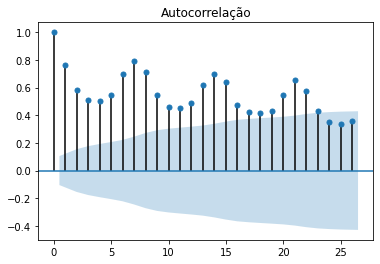

In [ ]:
plot_acf(df_ts['casosNovos'], title='Autocorrelação');

Aparenta ter uma autocorrelação auta a cada 7.

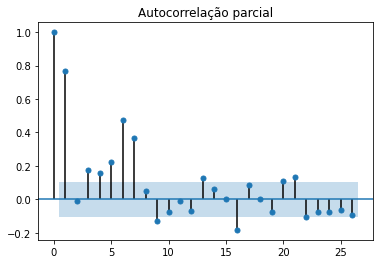

In [ ]:
plot_pacf(df_ts['casosNovos'], title='Autocorrelação parcial');

Aparenta ter uma autocorrelação parcial auta a cada 7 tambem.

Ja que os dados tem uma alta *correlação* e *corelação parcial* em 7, vamos usar esta frequência então para fazer a decomposição da nossa série temporal.

In [ ]:
result = seasonal_decompose(df_ts['casosNovos'], freq=7)

from plotly.subplots import make_subplots
fig = make_subplots(rows=4, cols=1)


fig.add_trace(
    go.Scatter(x=result.observed.index,
               y=result.observed.values,
               name='Observado'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=result.trend.index,
               y=result.trend.values,
               name='Tendência'
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=result.seasonal.index,
               y=result.seasonal.values,
               name='Sazonalidade'
    ),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=result.resid.index,
               y=result.resid.values,
               name='Resíduo'
    ),
    row=4, col=1
)

fig.update_layout(
    hovermode='x',
     title={
        'text': 'Decomposição sazonal<br>numero de novos casos de COVID-19 no Brasil',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

#Tentando prever o numero de casos futuros

Agora que ja entendemos como nossa série temporal esta se comportando vamos tentar prever o numero de novos casos no futuro.

In [ ]:
# separarando dados de treino e dados de teste
train = df_ts.query('index.dt.year != 2021').reset_index().rename({'casosNovos': 'y', 'data': 'ds'}, axis=1)
test = df_ts.query('index.dt.year == 2021').reset_index().rename({'casosNovos': 'y', 'data': 'ds'}, axis=1)

In [ ]:
# criando e treinando modelo
prophet_model = Prophet(yearly_seasonality=True).fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# fazendo previsoes
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
prophet_prediction = prophet_model.predict(future)

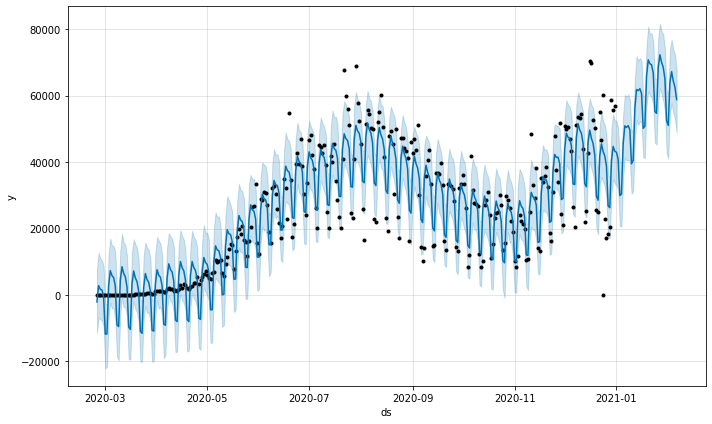

In [ ]:
prophet_model.plot(prophet_prediction);

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
        y=test['y'],
        x=prophet_prediction.index+train.index.max(),
        name='Dados reais',
        line={'color': 'red'}
    )
)

fig.add_trace(go.Scatter(
        y=prophet_prediction[-len(test):]['yhat'],
        x=prophet_prediction.index+train.index.max(),
        name='Previsão',
        line={'color': 'blue'}
    )
)

fig.update_layout(
   hovermode='x',
     title={
        'text': 'Previsão x Dados reais',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

## Testando acurácia do modelo

In [ ]:
mean_squared_error(test['y'], prophet_prediction[-len(test):]['yhat'])

406559224.0615717

In [ ]:
mean_absolute_error(test['y'], prophet_prediction[-len(test):]['yhat'])

15234.454987503786